# 📘 BRFSS SDOH Health Risk Scorecard

## 1. Load and Combine BRFSS Datasets (Multiple Years)

The Behavioral Risk Factor Surveillance System (BRFSS) data is stored across multiple CSV files (one per year).  
We use `glob` to iterate over all `.csv` files in the `data/` folder, read them, add a `YEAR` column, and concatenate them into a single DataFrame.

In [1]:
# 01_EDA_Preprocessing.ipynb
# SDOH Health Risk Scorecard - Data Loading, Cleaning, EDA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

# Set pandas display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [2]:
# 1. Loading and Combining All BRFSS Datasets
# ----------------------
data_path = "data/"
datasets = glob.glob(os.path.join(data_path, "*.csv"))

all_data = []
for file in datasets:
    df = pd.read_csv(file, low_memory=False)
    year = int(os.path.basename(file).split(".")[0])
    df["YEAR"] = year
    all_data.append(df)

brfss = pd.concat(all_data, ignore_index=True)
print("Combined shape:", brfss.shape)


Combined shape: (2380047, 645)


## Step 2: Set Display Options for Readability
To make dataframes more readable during EDA, we increase the display limits for columns and rows in pandas.

In [3]:
# 2. Initial Feature Selection (Subset for SDOH + Health)
# ----------------------
selected_columns = [
    'YEAR', 'SEX', 'AGE', 'EDUCA', 'INCOME2', 'EMPLOY1', 'MARITAL',
    '_SMOKER3', '_DRNK3GE5', '_SLEPTIM1', '_TOTINDA', '_HLTHPL1',
    'DIABETE3', '_BMI5', 'GENHLTH', '_MENT14D'
]
available_cols = [col for col in selected_columns if col in brfss.columns]
brfss = brfss[available_cols]
print("Selected Columns:", available_cols)

Selected Columns: ['YEAR', 'SEX', 'AGE', 'EDUCA', 'INCOME2', 'EMPLOY1', 'MARITAL', '_SMOKER3', '_TOTINDA', 'DIABETE3', '_BMI5', 'GENHLTH']


## Step 3: Handle Missing and Special Codes
BRFSS datasets often use special codes like 7, 9, 77, 88, 99, etc., to denote missing or invalid values.
We will replace such values with NaN to allow correct statistical handling during analysis.

In [4]:
# 3. Handle Missing and Special Codes
def clean_special_codes(df):
    for col in df.columns:
        if df[col].dtype in [np.int64, np.float64]:
            df[col] = df[col].replace([7, 9, 77, 88, 99, 999, 9999], np.nan)
    return df

brfss = clean_special_codes(brfss)

## Step 4: Encode Categorical Variables
Some key demographic and socioeconomic columns such as SEX, EDUCA, INCOME2, etc., will be encoded as categorical variables to improve readability and analysis compatibility.

In [5]:
# 4. Encode Categorical Variables
categorical_cols = ['SEX', 'EDUCA', 'INCOME2', 'EMPLOY1', 'MARITAL', 'GENHLTH']
for col in categorical_cols:
    if col in brfss.columns:
        brfss[col] = brfss[col].astype('category')

## Step 5: Create Binary Target Variable — HIGH_RISK
We define a custom binary target called HIGH_RISK based on the presence of key risk factors:
- Has diabetes (DIABETE3 == 1)
- High BMI (BMI > 30.0; stored as _BMI5 > 3000)
- Physical inactivity (_TOTINDA == 2)
- No health insurance (_HLTHPL1 == 2)
If any of these conditions are met, the individual is marked as HIGH_RISK = 1, else 0.

In [6]:
# Step 5: Create Binary Target Variable (HIGH_RISK)
# Defining fallback conditions if columns are missing
has_diabetes = brfss['DIABETE3'] == 1 if 'DIABETE3' in brfss.columns else False
high_bmi = brfss['_BMI5'] > 3000 if '_BMI5' in brfss.columns else False  # BMI * 100
inactive = brfss['_TOTINDA'] == 2 if '_TOTINDA' in brfss.columns else False
no_insurance = brfss['_HLTHPL1'] == 2 if '_HLTHPL1' in brfss.columns else False

# Combining conditions to define high-risk individuals
brfss['HIGH_RISK'] = (
    has_diabetes |
    high_bmi |
    inactive |
    no_insurance
).astype(int)

## Step 6: Exploratory Data Analysis (EDA)
We perform basic EDA to understand the distribution of the new target variable and key health indicators:
Bar chart showing the count of Low vs High risk individuals.
Histogram of BMI distribution.
Pie chart showing proportion of high-risk individuals in the population.
Line chart showing percentage of high-risk individuals over time (year-wise).

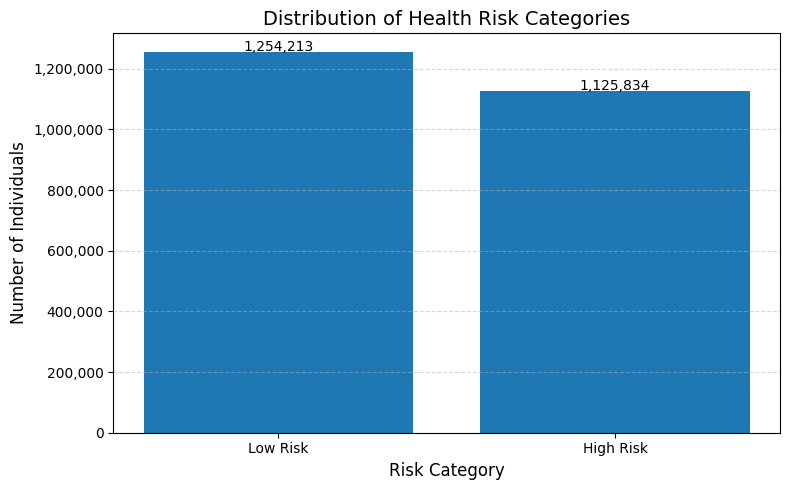

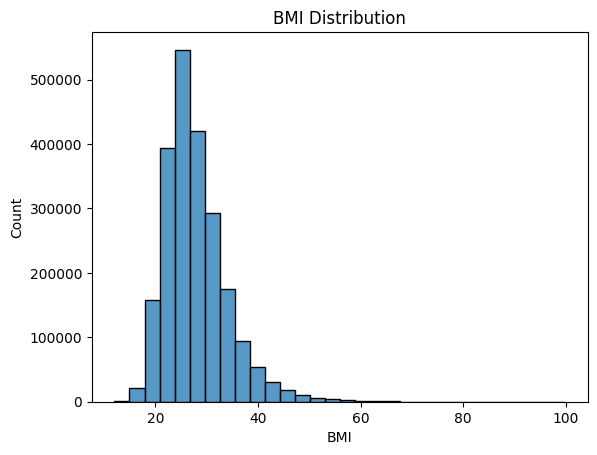

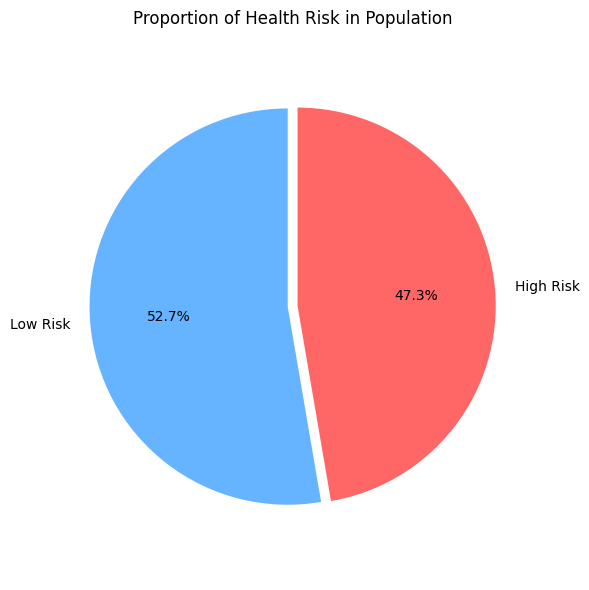

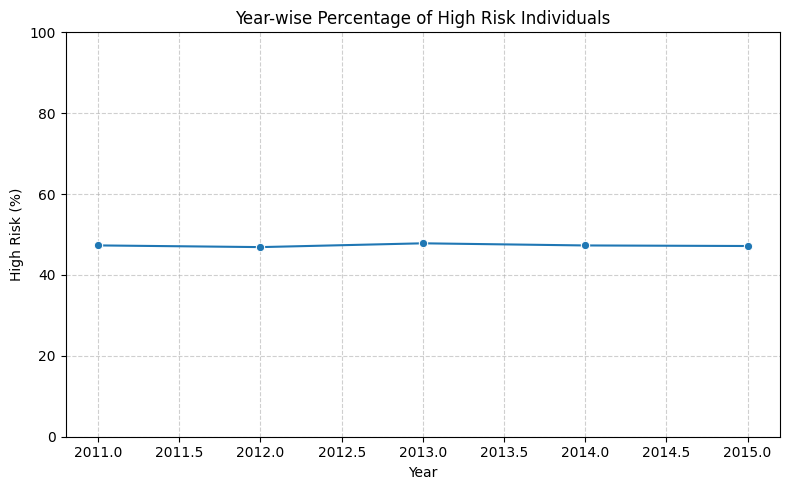

In [11]:
# 6. Exploratory Data Analysis (EDA)
import matplotlib.ticker as mtick
import seaborn as sns

# Counting high risk vs low risk
risk_counts = brfss['HIGH_RISK'].value_counts().sort_index()
risk_labels = ['Low Risk', 'High Risk']
plt.figure(figsize=(8, 5))
bars = plt.bar(risk_labels, risk_counts)

# Adding value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 5000, f"{height:,.0f}", ha='center', fontsize=10)

# Formatting y-axis with commas instead of scientific notation
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:,.0f}'))

# Labels and title
plt.title("Distribution of Health Risk Categories", fontsize=14)
plt.xlabel("Risk Category", fontsize=12)
plt.ylabel("Number of Individuals", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

sns.histplot(brfss['_BMI5'].dropna() / 100, bins=30)
plt.title("BMI Distribution")
plt.xlabel("BMI")
plt.show()

labels = ['Low Risk', 'High Risk']
sizes = brfss['HIGH_RISK'].value_counts().sort_index()
colors = ['#66b3ff', '#ff6666']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, explode=(0, 0.05))
plt.title("Proportion of Health Risk in Population")
plt.axis('equal')  # Equal aspect ratio ensures pie is circular
plt.tight_layout()
plt.show()

# Group by year and calculate high-risk percentage
risk_by_year = brfss.groupby('YEAR')['HIGH_RISK'].mean().reset_index()
risk_by_year['HIGH_RISK'] *= 100  # convert to %

plt.figure(figsize=(8, 5))
sns.lineplot(data=risk_by_year, x='YEAR', y='HIGH_RISK', marker='o')
plt.title("Year-wise Percentage of High Risk Individuals")
plt.xlabel("Year")
plt.ylabel("High Risk (%)")
plt.ylim(0, 100)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
# ----------------------

In [8]:
# 7. Saving Cleaned Dataset
# ----------------------
brfss.to_csv("data/brfss_combined_cleaned.csv", index=False)
print("Saved cleaned dataset with shape:", brfss.shape)

Saved cleaned dataset with shape: (2380047, 13)


## Conclusion: Data Preparation and EDA
- In this initial phase, we successfully consolidated multiple years of BRFSS data into a unified dataset, ensuring consistent formatting and handling of special codes.
- We encoded key demographic variables and engineered a binary target variable (HIGH_RISK) based on critical health risk indicators.
- Exploratory Data Analysis revealed important patterns in risk distribution across individuals and time.
- This cleaned dataset now provides a solid foundation for predictive modeling and deeper health risk analysis in the next stages of the project.